In [1]:
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In this demo, we will go over how to identify MSI status of ONT sequencing data using two samples from SG-NEx dataset (A549 - MSS and HCT116 - MSI).

The BAM files for A549 and HCT116 are provided in the NanoMnT GitHub repostiory, under `~/tutorial/data/*`. <br/>
These BAM files are subsampled from the original data. <br/>
If you want to use the entire data, (1) download the raw FASTQ files from SG-NEx (direct cDNA), (2) align them to the T2T-CHM13v2.0 genome using `minimap2`, then (3) filter out non-primary reads and reads with MAPQ<60 using `~/NanoMnT/NanoMnT/utility/filterBAMbyMAPQ.py`. <br/>

In [2]:
""" 
Change the following PATHs accordingly to your settings 
"""

DIR_nanomnt_git = '/home/18parkky/git/NanoMnT'
DIR_workspace = f'{DIR_nanomnt_git}/tutorial/data'

PATH_A549_BAM   = f'{DIR_nanomnt_git}/tutorial/data/SG-NEX.A549.test.sorted.bam'
PATH_HCT116_BAM = f'{DIR_nanomnt_git}/tutorial/data/SG-NEX.HCT116.test.sorted.bam'

PATH_krait = f'{DIR_nanomnt_git}/ref/krait/raw/T2T-CHM13v2.0/T2TCHM13v2.0-1bp_STR.tsv.gz'
PATH_reference_genome = '~/18parkky/datasets/reference/genome/chm13v2.0.fa'

## Running `estimateLociCoverage` (optional)

Although optional, estimating STR loci coverage and excluding loci with no coverage before running `getAlleleTable` can considerably reduce runtime. <br/>
In this demo, we will use 20 as coverage threshold.

In [3]:
# 4~5 minutes
!estimateLociCoverage -b {PATH_A549_BAM} -s {PATH_krait} -cov 20 -out {DIR_workspace}
!estimateLociCoverage -b {PATH_HCT116_BAM} -s {PATH_krait} -cov 20 -out {DIR_workspace}

In [4]:
# The following krait files will be used for getAlleleTable
PATH_krait_A549     = f'{DIR_workspace}/T2TCHM13v2.0-1bp_STR.tsv-SG-NEX.A549.test.sorted.coverageLabeled.highCov.tsv'
PATH_krait_HCT116   = f'{DIR_workspace}/T2TCHM13v2.0-1bp_STR.tsv-SG-NEX.HCT116.test.sorted.coverageLabeled.highCov.tsv'

## Running `getAlleleTable`

Using the krait files created above, we will run `getAlleleTable` for each BAM, which will give us the STR information of each sample in read-level. <br/>
Since MSI phenotype is most prominently observed in 1bp-STR loci, we will use 1bp STR loci from the T2T-CHM13 genome.

※Running `getAlleleTable` directly on notebooks is discouraged due to `minimap2`'s verbose outputs. However, since we are processing only a few loci, we will proceed. 

In [5]:
# ~2 minutes
!getAlleleTable -b {PATH_A549_BAM} -s {PATH_krait_A549} -r {PATH_reference_genome} -m 60 -f 12 -t 4 -out {DIR_workspace}
!getAlleleTable -b {PATH_HCT116_BAM} -s {PATH_krait_HCT116} -r {PATH_reference_genome} -m 60 -f 12 -t 4 -out {DIR_workspace}

[M::mm_idx_gen::0.003*1.89] collected minimizers
[M::mm_idx_gen::0.005*1.48] sorted minimizers
[M::main::0.005*1.47] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.005*1.44] mid_occ = 31
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.005*1.42] distinct minimizers: 6985 (96.85% are singletons); average occurrences: 1.084; average spacing: 5.288; total length: 40050
[M::mm_idx_gen::0.003*1.83] collected minimizers
[M::mm_idx_gen::0.006*1.37] sorted minimizers
[M::main::0.006*1.36] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.006*1.34] mid_occ = 31
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.007*1.32] distinct minimizers: 6997 (96.88% are singletons); average occurrences: 1.084; average spacing: 5.282; total length: 40050
[M::mm_idx_gen::0.002*1.86] collected minimizers
[M::mm_idx_gen::0.006*1.32] sorted minimizers
[M::main::0.006*1.32] loaded/built the index for 1 targ

### Interpreting allele tables

Although we primarily encourage using locus tables (generated by `getLocusTable` in the next step) for detecting MSI, we can still get a good overview of STR allele profile using allele tables. <br/> 
Allele tables contain information of reads that align to the user-specified STR loci.

In [6]:
PATH_A549_alleleTable = f'{DIR_workspace}/SG-NEX.A549.test.sorted.STR_allele_table.tsv'
PATH_HCT116_alleleTable = f'{DIR_workspace}/SG-NEX.HCT116.test.sorted.STR_allele_table.tsv'

alleleTable_A549    = pd.read_csv(PATH_A549_alleleTable, sep='\t')
alleleTable_HCT116  = pd.read_csv(PATH_HCT116_alleleTable, sep='\t')

alleleTable_A549['sample'] = 'A549'
alleleTable_HCT116['sample'] = 'HCT116'

alleleTable = pd.concat( [alleleTable_A549, alleleTable_HCT116] )
alleleTable.reset_index(inplace=True, drop=True)

In [7]:
alleleTable.head(3)

,read_name,locus,repeat_unit,allele,reference_STR_allele,left_flanking_seq,right_flanking_seq,flag,CB,UMI,corrected_allele,editing_distance,read_STR_allele,sample
0,905b0c7e-7f72-4e4f-90c8-5fa0c8066513,chr10:17256074-17256083,T,TTTTTTTTTT,10,CA*TAAAACTGC,CCAGCAAGTATC,16,NaN,NaN,TTTTTTTTTT,0,10,A549
1,7760f5d1-2ce5-4965-92a5-02f35f3faff1,chr10:17256074-17256083,T,TTTTTTTTT,10,CATTAAAACTGC,CCAGCAAGTATC,16,NaN,NaN,TTTTTTTTT,0,9,A549
2,89fc19b0-93f6-42e2-a121-36ce802bd9c5,chr10:17256074-17256083,T,TTTTTTT,10,CATTcAAAcAC***,CCAGCAAGTATC,0,NaN,NaN,TTTTTTT,0,7,A549


As demonstrated in our paper (Figure 9), MSS cells exhibit STR allele profiles closely resembling the reference genome (T2T-CHM13), whereas MSI cells display significantly shorter STR allele profiles due to frequent deletion mutations. <br/>
For each read, we will calculate the STR allele difference relative to the reference genome and visulize the results using Seaborn and Matplotlib.

In [8]:
# relative_difference>0 indicates longer STR allele relative to the reference, whereas relative_difference< indicates shorter allele relative to the reference
alleleTable['relative_difference'] = alleleTable['read_STR_allele'] - alleleTable['reference_STR_allele']    

As we can see below, HCT116 displays a slight enrichment of shorter STR alleles compared to the reference genome, while A549 is overall similar to the reference genome. <br/>
Nonetheless, to be sure, we must have locus-level information of STR alleles for each sample.

<Axes: xlabel='sample', ylabel='relative_difference'>

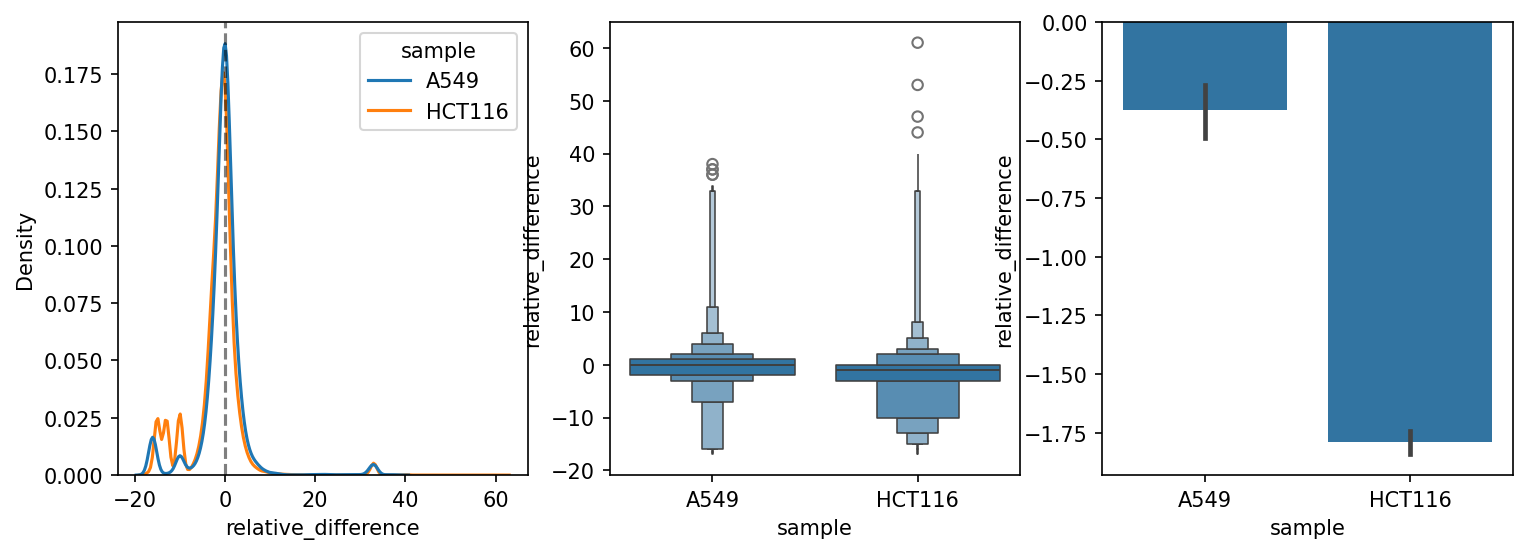

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
sns.kdeplot(data=alleleTable, x='relative_difference', hue='sample', common_norm=False, ax=axes[0])
axes[0].axvline( 0, color='black', ls='--', alpha=0.5, )
sns.boxenplot(data=alleleTable, x='sample', y='relative_difference', ax=axes[1])
sns.barplot(data=alleleTable, x='sample', y='relative_difference', ax=axes[2])

## Running *getLocusTable*

However, consdering the high sequencing error rate of ONT, we must be careful when drawing conclusion using allele tables (read-level information). <br/>
We procede by running `getLocusTable`, which will group reads that align to the same loci and estimate STR allele for each locus with sufficient coverage. <br/>

### Using all reads for estimating STR allele

In [10]:
# ~20 seconds
DIR_getLocusTable_out1 = f'{DIR_workspace}/locusTable_all_reads'
if os.path.exists( DIR_getLocusTable_out1 ) == False: os.mkdir( DIR_getLocusTable_out1 )

!getLocusTable -at {PATH_A549_alleleTable} -read_selection all_reads -cov 20 -t 4 -out {DIR_getLocusTable_out1}
!getLocusTable -at {PATH_HCT116_alleleTable} -read_selection all_reads -cov 20 -t 4 -out {DIR_getLocusTable_out1}

In [11]:
PATH_A549_locusTable_1      = f'{DIR_workspace}/locusTable_all_reads/SG-NEX.A549.test.sorted.STR_allele_table.STR_locus_table.tsv'
PATH_HCT116_locusTable_1    = f'{DIR_workspace}/locusTable_all_reads/SG-NEX.HCT116.test.sorted.STR_allele_table.STR_locus_table.tsv'

A549_locusTable_1   = pd.read_csv(PATH_A549_locusTable_1, sep='\t')
HCT116_locusTable_1 = pd.read_csv(PATH_HCT116_locusTable_1, sep='\t')

A549_locusTable_1['sample']     = 'A549'
HCT116_locusTable_1['sample']   = 'HCT116'

In [12]:
locusTable_1 = pd.concat( [A549_locusTable_1, HCT116_locusTable_1] )
locusTable_1.reset_index(inplace=True, drop=True)

locusTable_1.head(3)

,chromosome,start,end,locus,repeat_unit,reference_STR_allele,percentage_of_reference_allele,correction_rate,corrected_read_count,allele,peak_pos,peak_prominence,num_peaks,int_relative_allele_size,histogram_area_relative_to_reference,read_selection,sample
0,chr7,135848301,135848312,chr7:135848301-135848312,A,12,0.137931,1.0,29,13,13,31.034483,3,1,1.965517,all_reads,A549
1,chrX,102122719,102122730,chrX:102122719-102122730,A,12,0.155602,1.0,964,13,13,19.813278,1,1,0.751037,all_reads,A549
2,chr6,64726670,64726684,chr6:64726670-64726684,T,15,0.207254,1.0,579,15,15,20.725389,2,0,0.029361,all_reads,A549


## Detecting MSI status

On the NanoMnT GitHub page, we define a metric called `histogram_area_relative_to_reference`. This value is calculated as the sum of `(STR allele - reference allele) × (observed frequency of the allele)` for each observed allele.

For a given locus, if the value of `histogram_area_relative_to_reference` is:

- ~0, it indicates that the STR allele is **similar** to the reference genome.<br/>
- \>0, it indicates STR allele is **longer** than the reference genome.<br/>
- \<0, it indicates STR allele is **shorter** than the reference genome.<br/>

As we can see below, estimating the genotype of sufficiently covered loci to obtain locus-level information substantially improves differentiation between MSI and MSS samples

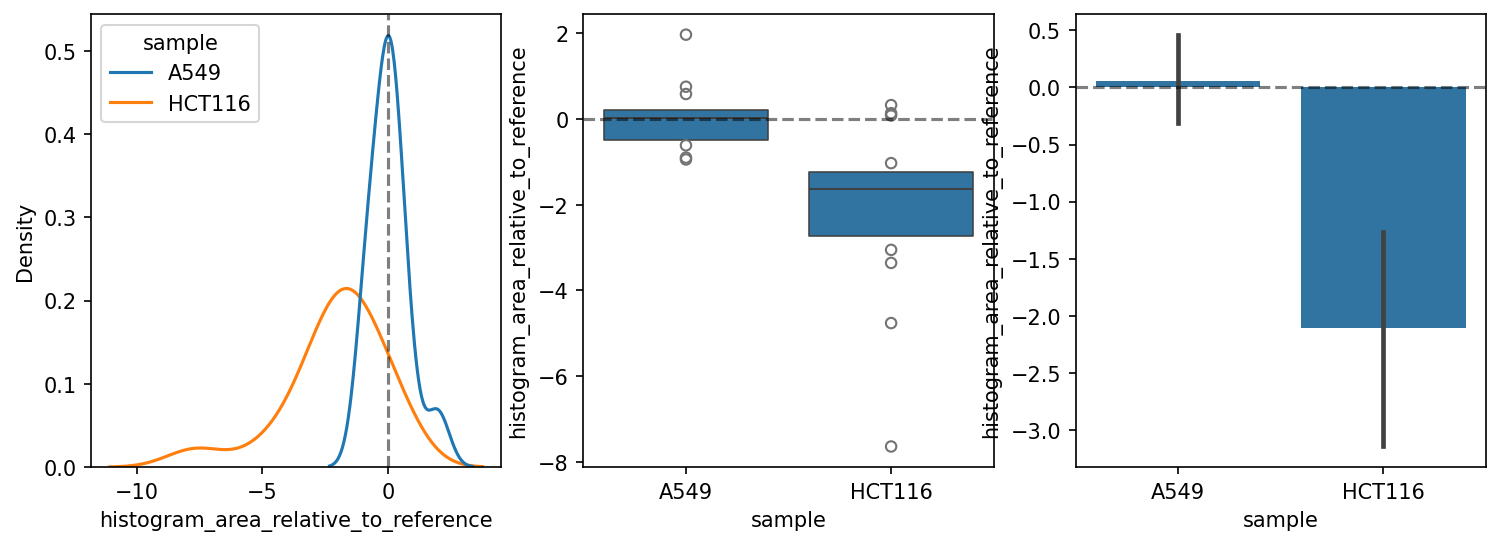

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
sns.kdeplot(data=locusTable_1, x='histogram_area_relative_to_reference', hue='sample', common_norm=False, ax=axes[0])
axes[0].axvline( 0, color='black', ls='--', alpha=0.5, )
sns.boxenplot(data=locusTable_1, x='sample', y='histogram_area_relative_to_reference', ax=axes[1])
axes[1].axhline( 0, color='black', ls='--', alpha=0.5, )
sns.barplot(data=locusTable_1, x='sample', y='histogram_area_relative_to_reference', ax=axes[2])
axes[2].axhline( 0, color='black', ls='--', alpha=0.5, )

To even further improve the accuracy of our results, we will use read-selection method by specifying `fw_rv_reads` in the `-read_selection` parameter of `getLocusTable`, where we only use reads whose A-repeats were sequenced. <br/>
That is, using:<br/> 
- forward reads (reads that map to the forward strand of the reference genome; e.g., flag=0) when analyzing A-repeat STR 
- reverse reads (reads that map to the reverse strand of the reference genome; e.g., flag=16) when analyzing T-repeat STR

In [14]:
# ~10 seconds
DIR_getLocusTable_out2 = f'{DIR_workspace}/locusTable_fw_rv_reads'
if os.path.exists( DIR_getLocusTable_out2 ) == False: os.mkdir( DIR_getLocusTable_out2 )

!getLocusTable -at {PATH_A549_alleleTable} -read_selection fw_rv_reads -cov 20 -t 4 -out {DIR_getLocusTable_out2}
!getLocusTable -at {PATH_HCT116_alleleTable} -read_selection fw_rv_reads -cov 20 -t 4 -out {DIR_getLocusTable_out2}

In [15]:
PATH_A549_locusTable_2      = f'{DIR_workspace}/locusTable_fw_rv_reads/SG-NEX.A549.test.sorted.STR_allele_table.STR_locus_table.tsv'
PATH_HCT116_locusTable_2    = f'{DIR_workspace}/locusTable_fw_rv_reads/SG-NEX.HCT116.test.sorted.STR_allele_table.STR_locus_table.tsv'

A549_locusTable_2   = pd.read_csv(PATH_A549_locusTable_2, sep='\t')
HCT116_locusTable_2 = pd.read_csv(PATH_HCT116_locusTable_2, sep='\t')

A549_locusTable_2['sample']     = 'A549'
HCT116_locusTable_2['sample']   = 'HCT116'

In [16]:
locusTable_2 = pd.concat( [A549_locusTable_2, HCT116_locusTable_2] )
locusTable_2.reset_index(inplace=True, drop=True)

locusTable_2.head(3)

,chromosome,start,end,locus,repeat_unit,reference_STR_allele,percentage_of_reference_allele,correction_rate,corrected_read_count,allele,peak_pos,peak_prominence,num_peaks,int_relative_allele_size,histogram_area_relative_to_reference,read_selection,sample
0,chrX,102122719,102122730,chrX:102122719-102122730,A,12,0.157526,1.0,857,13,13,20.420070,1,1,0.827305,fw_rv_reads,A549
1,chr6,64726670,64726684,chr6:64726670-64726684,T,15,0.214000,1.0,500,15,15,21.400000,2,0,0.022000,fw_rv_reads,A549
2,chr6,64727084,64727093,chr6:64727084-64727093,T,10,0.404059,1.0,542,10,10,40.405904,1,0,-0.771218,fw_rv_reads,A549


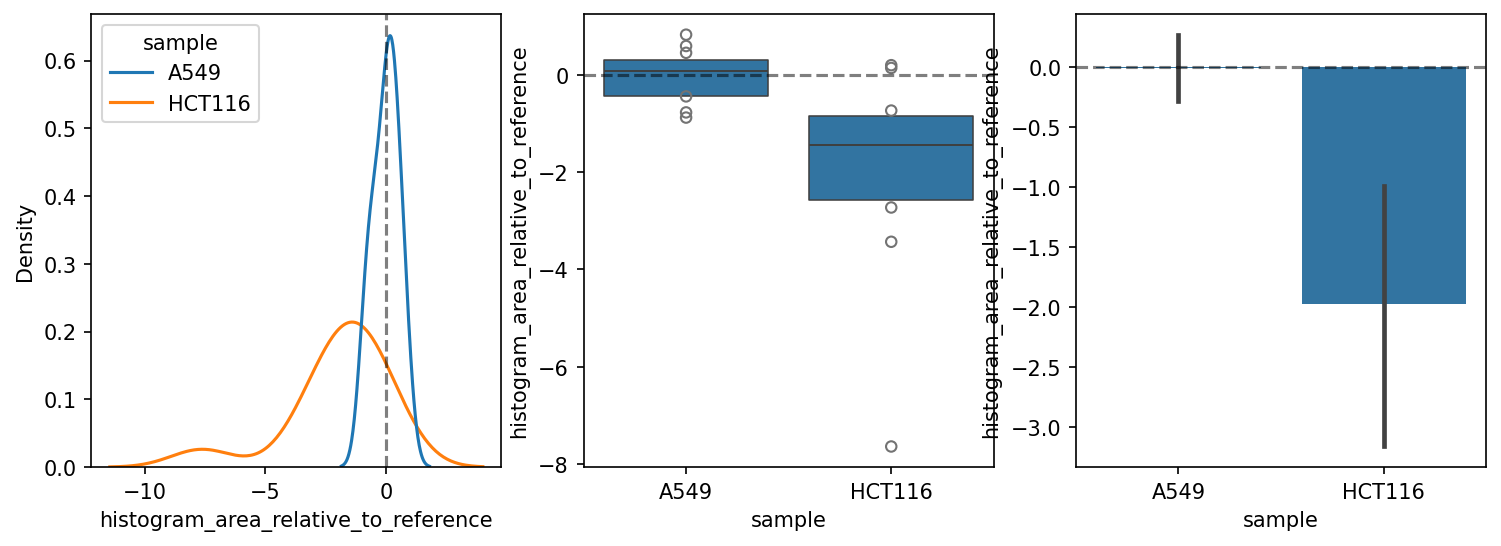

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
sns.kdeplot(data=locusTable_2, x='histogram_area_relative_to_reference', hue='sample', common_norm=False, ax=axes[0])
axes[0].axvline( 0, color='black', ls='--', alpha=0.5, )
sns.boxenplot(data=locusTable_2, x='sample', y='histogram_area_relative_to_reference', ax=axes[1])
axes[1].axhline( 0, color='black', ls='--', alpha=0.5, )
sns.barplot(data=locusTable_2, x='sample', y='histogram_area_relative_to_reference', ax=axes[2])
axes[2].axhline( 0, color='black', ls='--', alpha=0.5, )

### Improvements by using read_selection method

To assess the improvement achieved by applying the read-selection method when running `getLocusTable`, we will calculate the intersection area between the STR allele profiles of MSS and MSI samples. <br/> A smaller intersection area indicates better distinguishability between the two samples.

In [18]:
from scipy.integrate import quad
from scipy.stats import gaussian_kde

def intersection_area(kde1, kde2, xmin, xmax):
    # Define the function to integrate: min(kde1(x), kde2(x))
    def min_function(x):
        return min(kde1(x), kde2(x))
    
    # Integrate the min_function over the specified range [xmin, xmax]
    area, _ = quad(min_function, xmin, xmax)
    
    return area

A small improvement is observed, as shown below (~9% decrease in intersection area). <br/>
However, it's important to note that we used a limited number of loci; using more reads would likely lead to a greater improvement.

In [19]:
A549_1      = gaussian_kde( locusTable_1[(locusTable_1['sample']=='A549')]["histogram_area_relative_to_reference"] )
HCT116_1    =  gaussian_kde( locusTable_1[(locusTable_1['sample']=='HCT116')]["histogram_area_relative_to_reference"] )

area_intersect_1 = intersection_area(A549_1, HCT116_1, -10, 10)
print(f'Area of intersection when not applying read-selection:\t{area_intersect_1}')

A549_2      = gaussian_kde( locusTable_2[(locusTable_2['sample']=='A549')]["histogram_area_relative_to_reference"] )
HCT116_2    =  gaussian_kde( locusTable_2[(locusTable_2['sample']=='HCT116')]["histogram_area_relative_to_reference"] )

area_intersect_2 = intersection_area(A549_2, HCT116_2, -10, 10)
print(f'Area of intersection when applying read-selection:\t{area_intersect_2}')

Area of intersection when not applying read-selection:	0.4174972334259116
Area of intersection when applying read-selection:	0.3832581524150742
